# **Computer Vision 600.661: Homework 2**
## **3D Camera Modeling**

### Dimitri Lezcano

### **Imports**

In [1]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import cv2
import matplotlib.pyplot as plt
import glob

### *Previous Functions*

Affine Transformations

In [2]:
def affine_2d_Ab(X, Y):
    ''' create the A matrix for affine transformation
    
        Args:
            - X: the source points ( N x 2 )
            - Y: the target points ( N x 2 )
            
        Returns:
            - A: the A (2*N x 6) matrix for least squares formulation
            - b: the b (2*N) vector for least squares formulation
    
    '''
    # initialize the matrices
    A = np.zeros( ( 2*X.shape[0], 6 ) )
    b = Y.reshape(-1)
    
    Xh = np.hstack( ( X, np.ones( ( X.shape[0], 1 ) ) ) )
#     Yh = np.hstack( ( Y, np.ones( ( X.shape[0], 1 ) ) ) )

    A[0::2, :3] = Xh
    A[1::2, 3:] = Xh
    
    
    
    return A, b
    
# affine_2d_Ab

def get_affinetransform(X, Y):
    ''' wrapper function for ease of use for affine transform'''
    A, b = affine_2d_Ab(source, target)
    t = la.inv(A.T @ A) @ A.T @ b # transform vector
    affine_transform = np.vstack((t.reshape(2,3), [0, 0, 1]))
    
    return affine_transform

# get_affinetransform

Homographies

In [3]:
def homography_2d_A(X, Y):
    ''' create the A matrix for homography transformation
    
        Args:
            - X: the source points ( N x 2 )
            - Y: the target points ( N x 2 )
            
        Returns:
            - A: the A (2*N x 9) matrix for least squares formulation
    
    '''
    # initialize the matrices
    A = np.zeros( ( 2*X.shape[0], 9 ) )
    
    Xh = np.hstack( ( X, np.ones( ( X.shape[0], 1 ) ) ) )

    A[:, 0:6] = affine_2d_Ab(X, Y)[0] 
    
    A[0::2, 6:] = -Y[:,0].reshape(-1,1) * Xh
    A[1::2, 6:] = -Y[:,1].reshape(-1,1) * Xh
    
    return A
    
# homography_2d_A

def solveA_svd(A):
    ''' Function to return the solution of:
        
        argmin_x ||A x||^2 
        
        Args:
            - A: the matrix
            
        Return:
            - x = argmin of above 1-D vector
            - s = the associated singular value
    
    '''
    # perform the svd of A
    u, s, vh = la.svd(A)
    
    # last singular value is the smallest 
    s_min = s[-1]
    v_min = vh[-1,:]
    v_min = v_min/la.norm(v_min)
    
    return v_min, s_min
    
# solveA_svd

def get_homography(X, Y):
    ''' wrapper function for ease of use for homography'''
    A = homography_2d_A(X, Y)

    t, s = solveA_svd(A)
    T = t.reshape(3,3)
    
    return T

# get_homography

def apply_homography(T, X):
    ''' applies homography to row-wise coordinates
        
        Args:
            - T  ( 3 x 3 ) homography transform
            - X  ( N x 2 ) points to be transform
    
    '''
    Xh = np.hstack( (X, np.ones((X.shape[0], 1)) ) )
    
    Yh = Xh @ T.T # project coordinates
    
    Yh /= Yh[:,-1].reshape(-1, 1) # normalize the scale coordinate
    
    return Yh[:,0:2]

# apply_homography    

Gradient Histogramming

In [4]:
def gradient_histw(grads, n_bins = 10, plot:bool=False):
    ''' function to compute the weighted histogram of gradients
        
        Args:
            - grads: [N x 2] array of (x, y) gradient vectors
            - n_binds: integer of the number of bins to use (Default = 10)
            - plot: plotting argument
            
        Returns:
            - theta: a `n_bins`-vector of the directions of gradients
            - histw: a `n_bins`-vector of the weighted histogram
            
    
    '''
    # compute theta array
    theta = np.linspace(0, 2*np.pi, n_bins)
    
    # compute gradient directions and magnitudes
    theta_grads = np.arctan2(grads[:,1], grads[:,0])
    mag_grads = la.norm(grads, axis=1)
    
    # reorient so angles are between 0 and 2*pi
    theta_grads[theta_grads < 0] += 2*np.pi
    
    # compute a histogram
    histw, bins = np.histogram(theta_grads, bins=theta, weights=mag_grads)
    
    if plot:
        plt.hist(np.rad2deg(theta_grads), bins=np.rad2deg(theta), weights=mag_grads)
        plt.xlabel('theta (degs)')
        plt.title('Histogram of Gradients')
    
    
    return theta, histw
    
# gradient_histw

RANSAC

In [5]:
def get_keypoint_coord_from_match(matches, kp1, kp2, index):
    """ Gets the keypoint coordinates that correspond to matches[index].
      For example, if we want to get the coordinates of the keypoints corresponding
      to the 10th matching pair, we would be passing

              get_keypoint_coord_from_match(matches, kp1, kp2, 10)

      Then it will return keypoint1, keypoint2, where
      keypoint1: [x, y] coordinate of the keypoint in img1 that corresponds to matches[10]
      keypoint2: [x, y] coordinate of the keypoint in img2 that corresponds to matches[10]
    """
    keypoint1 = [kp1[matches[index].queryIdx].pt[0], kp1[matches[index].queryIdx].pt[1]]
    keypoint2 = [kp2[matches[index].trainIdx].pt[0], kp2[matches[index].trainIdx].pt[1]]
    return keypoint1, keypoint2

# get_keypoint_coord_from_match

def ransac(matches, kp1, kp2, num_samples: int = 6, num_trials: int = 3000,
           inlier_thresh: int = 5):
    
    # Some parameters
    total_matches = len(matches)
    
    # To keep track of the best transformation
    xform = np.zeros((3, 3))
    most_inliers = 0

    # turn the keypts into a numpy array: rows are the x-y coordinates
    keypts1 = []
    keypts2 = []
    for idx in range(total_matches):
        keypt1, keypt2 = get_keypoint_coord_from_match(matches, kp1, kp2, idx)
        
        keypts1.append(keypt1)
        keypts2.append(keypt2)
    # for
    
    keypts1 = np.array(keypts1).astype(np.float32)
    keypts2 = np.array(keypts2).astype(np.float32)
    
    # Loop through num_trials times
    for i in range(num_trials):

        # Randomly choose num_samples indices from total number of matches
        choices = np.random.choice(total_matches, num_samples, replace=False)

        # Get the matching keypoint coordinates from those indices
        keypts1_choice = keypts1[choices,:]
        keypts2_choice = keypts2[choices,:]

        # get homography   
        xform_i = get_homography(keypts1_choice, keypts2_choice)

        # count the number of inliers
        keypts1_xform_i = apply_homography(xform_i, keypts1)
        dists_i = la.norm(keypts1_xform_i - keypts2, axis=1)
        num_inliers = np.count_nonzero(dists_i <= inlier_thresh)

        # If for this transformation we have found the most inliers update most_inliers and xform
        if num_inliers > most_inliers:
            most_inliers = num_inliers
            xform = np.copy(xform_i)

        # if

    # for
    
    return xform
    
# ransac

Image Homography calculations using feature matching

In [6]:
def compute_img_homography(img1, img2, num_samples: int = 6, num_trials: int = 3000,
           inlier_thresh: int = 5):
    ''' Function to compute the image homography using RANSAC
        Computes transform to warp img1 -> img2
    
    '''
    
    # orb feature detector
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    
    # create a BFMather object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    # match descriptors
    matches = bf.match(des1, des2)
    
    # sort them in the order of their distance
    matches = sorted(matches, key = lambda x: x.distance)
    
    xform = ransac(matches, kp1, kp2, num_samples=num_samples,
                  num_trials=num_trials, inlier_thresh=inlier_thresh)
    
    return xform

# compute_img_homography

Inverse warping function: Previous Code

In [7]:
def get_pixel_contributions(x, y):
    """ Gets the overlapped pixels along with the relative contributions.
      Args:
        x: The x-coordinate
        y: The y-coordinate
      Return:
        pixel_contributions: List of [x, y, contribution] where (x, y) are the coordinates of
                             pixels that the input overlaps with.
    """

    pixel_contributions = []
    
    # find the ranges of x
    if int(x) == x and False: # integer
        range_x = [int(x)]
        
    else:
        range_x = [int(x), int(x) + 1]
        
    # find the ranges of y
    if int(y) == y and False: # integer
        range_y = [int(y)]
        
    else:
        range_y = [int(y), int(y) + 1]
        
    # iterate through the ranges
    for xi in range_x:
        for yi in range_y:
            # calculate the overlap
            overlap_x = 1-abs(x - xi)
            overlap_y = 1-abs(y - yi)
            
            # calculate the contribution
            contribute = overlap_x * overlap_y
            
            # add the contribution
            pixel_contributions.append([xi, yi, contribute])
            
        # for
    # for
    
    return np.array(pixel_contributions)

# get_pixel_contributions

def get_pixel_contributions_arr(X, Y):
    pixel_contributions = np.zeros((4*X.shape[0], 3))
    
    Xr = X.astype(int)
    Yr = Y.astype(int)
    
    Xrep = X.repeat(4)
    Yrep = Y.repeat(4)
    
    # set the x-coordinates
    pixel_contributions[0::4, 0] = Xr
    pixel_contributions[1::4, 0] = Xr
    pixel_contributions[2::4, 0] = Xr + 1
    pixel_contributions[3::4, 0] = Xr + 1
    
    # set the y-coordinates
    pixel_contributions[0::4, 1] = Yr
    pixel_contributions[2::4, 1] = Yr
    pixel_contributions[1::4, 1] = Yr + 1
    pixel_contributions[3::4, 1] = Yr + 1
    
    # measure the contributions
    overlap_x = 1 - np.abs(pixel_contributions[:,0] - Xrep)
    overlap_y = 1 - np.abs(pixel_contributions[:,1] - Yrep)
    
    pixel_contributions[:,2] = overlap_x * overlap_y
    
    return pixel_contributions
    
# get_pixel_contributions_arr

def inverse_warp(transform, image, cols:int= None, rows:int=None):
    
    # image checking
    if image.ndim < 3:
        image = np.expand_dims(image, 2).repeat(3, axis=2)
        
    # if
    
    elif image.shape[2] == 1:
        image = image.repeat(3, axis=2)
        
    # elif
    
    if cols is None:
        cols = image.shape[1]
    
    if rows is None:
        rows = image.shape[0]

    output_image = np.zeros((rows, cols, 3), dtype=float)

    # Invert the transformation matrix
    transform = la.inv(transform)
    
    # get the pixel coordinates
    X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
    pts = np.hstack((X.reshape(-1,1), Y.reshape(-1,1)))
    
    # transform the pixel coordinates
    pts_transformed = apply_homography(transform, pts) 
    
    # get the pixel contributions shape rows*cols x 4 x 3
    contributions = get_pixel_contributions_arr(pts_transformed[:,0], pts_transformed[:,1])
    idxs = contributions[:,0:2].astype(int)
    
    invalid_idxs = (idxs < 0).any(axis=1) | (idxs[:,1] >= image.shape[0]) | (idxs[:,0] >= image.shape[1])
    
    # cancel out contributions and default invalid index to origin
    contributions[invalid_idxs, :] = 0
    idxs = contributions[:,0:2].astype(int) # reset the idxs
    
    # get the contributions
    contrib_pxs = contributions[:,-1].reshape(-1,1) * image[idxs[:,1], idxs[:,0]]
    
    # perform the inverse warping 
    output_image[pts[:,1], pts[:,0]] += contrib_pxs[0::4]
    output_image[pts[:,1], pts[:,0]] += contrib_pxs[1::4]
    output_image[pts[:,1], pts[:,0]] += contrib_pxs[2::4]
    output_image[pts[:,1], pts[:,0]] += contrib_pxs[3::4]
        

    return output_image.astype(np.uint8)

# inverse_warp

Image stitching functions

In [8]:
def blend_images(image1, image2):
    ''' Blends the images from image1 and image2
        We assume that the image1 warped into plane of image2
        
        Method: simple feather blending on overlaps
    '''
    # compute the alpha matrix
    a1 = np.any(image1 != 0, axis=2) * 1
    a2 = np.any(image2 != 0, axis=2) * 0.3
    
    alpha = np.expand_dims(a1 - a2, axis=2)
    alpha[alpha < 0] = 0
    
    # blend the images
    image = alpha * image1 + ( 1 - alpha) * image2
    
    return image.astype(int)

# blend_images

def pw_homography(images: list):
    ''' Computes the pairwise homography from the center image
    
        Args:
            - images: list of N images
            
        Returns:
            - list of warped images to the center image plane
            - list of homographies from the center image
            
    
    '''
    
    # get the center image
    center_img = images[len(images)//2]
    
    # compute pairwise homographies
    homographies = []
    for img in images:
        H = compute_img_homography(img, center_img, num_samples=10, inlier_thresh = 1.5, num_trials=6000) 
        homographies.append(H)
        
    # for
    
    warped_images = []
    for H, img in zip(homographies, images):
        warped_img = inverse_warp(H, img, cols=center_img.shape[1], rows=center_img.shape[0])
        warped_images.append(warped_img)
        
    # for

    mosaicked_img = warped_images[len(images)//2]
    for warped_img in warped_images:
        mosaicked_img = blend_images(warped_img, mosaicked_img)
    
    return mosaicked_img, warped_images, homographies

# pw_homography   



### **Camera Calibration**

For these questions, you will find the following tutorial useful:
* OpenCV: Camera calibration With OpenCV - https://docs.opencv.org/3.4/d4/d94/tutorial_camera_calibration.html


#### Part 1) Part 1 (10 pts): Calibrating a stereo camera: In calib_imgs you will find a series of image pairs taken from a stereo camera setup. The folders “1” and “2” contain the series from each camera. Calibrate each camera individually and report its calibration parameters using the openCV camera calibration function findChessboardCorners and calibrate Camera Camera Calibration and 3D Reconstruction — OpenCV 2.4.13.7 documentation.
https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html


#  left images: 29
# right images: 29

# cb pts , cb dtype , cb shape
54 , float32 , (54, 3)

Left camera:
ret_l 0.5791565122825472
calibration matrix:
 [[465.3492017    0.         316.23802914]
 [  0.         465.24007823 186.90779073]
 [  0.           0.           1.        ]]
distortion coefficients:
 [[ 0.11202893 -0.18986182 -0.0012957  -0.00109452 -0.0367742 ]]

Right camera:
ret_r 0.5369832696611491
calibration matrix:
 [[467.36026364   0.         329.81122801]
 [  0.         466.95927221 176.98351984]
 [  0.           0.           1.        ]]
distortion coefficients:
 [[ 0.12156842 -0.21149111 -0.00225964  0.00115457  0.05606801]]



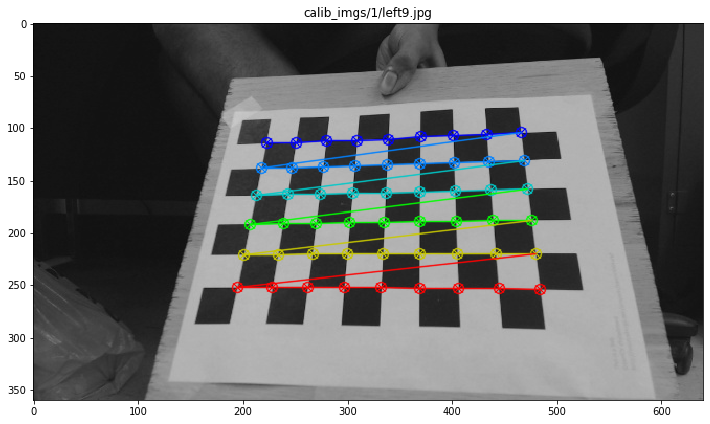

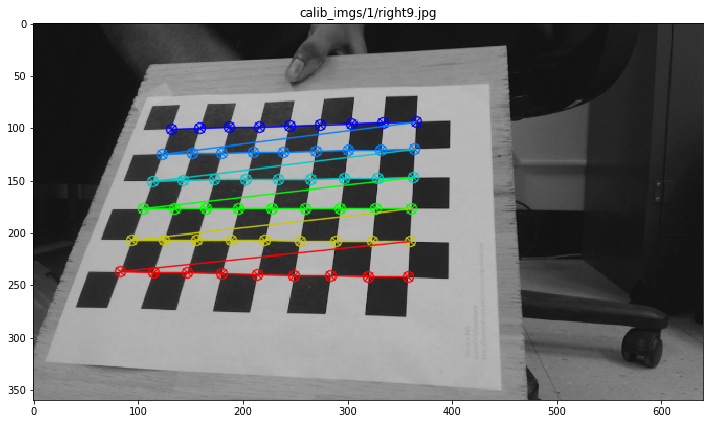

In [9]:
# get the image lists
left_imgs = sorted([f.replace('\\', '/') for f in glob.glob('calib_imgs/1/left*.jpg')])
right_imgs = sorted([f.replace('\\', '/') for f in glob.glob('calib_imgs/1/right*.jpg')])
print('#  left images:', len(left_imgs))
print('# right images:', len(right_imgs))
print()

# chessboard set-up
cb_size = (9, 6)
cb_pts = np.mgrid[0:cb_size[0], 0:cb_size[1],0:1].T.reshape(-1,3).astype(np.float32)

print('# cb pts , cb dtype , cb shape')
print(np.cumprod(cb_size)[-1], ',', cb_pts.dtype, ',', cb_pts.shape)
print()

# calibration set-up
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) # taken from opencv-python docs

# calibrate left camera
## gather the chessboard corner points
objpoints_l = []
imgpoints_l = []

for img_file in left_imgs:
    img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE) # read in the image as a grayscale
    
    # find the chess board points
    ret, corners = cv2.findChessboardCorners(img, cb_size, None)
    
    # if we found corners
    if ret == True:
        objpoints_l.append(cb_pts)
        
        # refine the corner points
        corners2 = cv2.cornerSubPix(img, corners, (11,11), (-1,-1), criteria) # taken from opencv-python docs
        imgpoints_l.append(corners2)
        
        
    # if
    
# for

# check the last img
draw_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
draw_img = cv2.drawChessboardCorners(draw_img, (9,6), corners2, ret)
plt.figure(figsize=(12,8))
plt.imshow(draw_img)
plt.title(img_file)

## perform camera calibration
ret_l, K_l, distortion_l, rvecs_l, tvecs_l = cv2.calibrateCamera(objpoints_l, imgpoints_l, img.shape[::-1],None,None)
print('Left camera:')
print('ret_l', ret_l)
print('calibration matrix:\n', K_l)
print('distortion coefficients:\n', distortion_l)
# print('rvecs_l', rvecs_l)
# print('tvecs_l', tvecs_l)
print()

# calibrate right camera
## gather the chessboard corner points
objpoints_r = []
imgpoints_r = []

for img_file in right_imgs:
    img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE) # read in the image as a grayscale
    
    # find the chess board points
    ret, corners = cv2.findChessboardCorners(img, cb_size, None)
    
    # if we found corners
    if ret == True:
        objpoints_r.append(cb_pts)
        
        # refine the corner points
        corners2 = cv2.cornerSubPix(img, corners, (11,11), (-1,-1), criteria) # taken from opencv-python docs
        imgpoints_r.append(corners2)
        
        
    # if
    
# for

# check the last img
draw_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
draw_img = cv2.drawChessboardCorners(draw_img, (9,6), corners2, ret)
plt.figure(figsize=(12,8))
plt.imshow(draw_img)
plt.title(img_file)

## perform camera calibration
ret_r, K_r, distortion_r, rvecs_r, tvecs_r = cv2.calibrateCamera(objpoints_r, imgpoints_r, img.shape[::-1],None,None)
print('Right camera:')
print('ret_r', ret_r)
print('calibration matrix:\n', K_r)
print('distortion coefficients:\n', distortion_r)
# print('rvecs_r', rvecs_r)
# print('tvecs_r', tvecs_r)
print()


### Part 2 (10 pts): Report the following: a) the transform that relates points in camera 2 to camera 1; and 2) the transforms that transform points from both cameras to a common rectified camera frame.

#### Part a) The transform relating camera 2 to camera 1
`(R_l2r, t_l2r)`

In [10]:
skew = lambda x: np.array([[0, -x[2], x[1]],[x[2], 0, -x[0]], [-x[1], x[0], 0]])
rotate3_z = lambda t: np.array([[np.cos(t), -np.sin(t), 0], [np.sin(t), np.cos(t), 0], [0, 0, 1]])

In [15]:
i = 0
Rl1 = cv2.Rodrigues(rvecs_l[i])[0].T
tl1 = -Rl1 @ tvecs_l[i].reshape(-1, 1)

Rr1 = cv2.Rodrigues(rvecs_r[i])[0].T
tr1 = -Rr1 @ tvecs_r[i].reshape(-1,1)


# compute R_l2r = inv(R_l) @ R_r
R_l2r = Rr1.T @ Rl1
t_l2r = Rr1.T @ (tl1 - tr1)

print('t_l2r:\n', t_l2r.reshape(-1))
print('R_l2r:\n', R_l2r)
print()


t_l2r:
 [-3.94982758 -0.05284769  0.13735426]
R_l2r:
 [[ 0.9996828  -0.00861024  0.02366776]
 [ 0.00866076  0.99996043 -0.002033  ]
 [-0.02364932  0.00223734  0.99971781]]



#### Part b) transforms to transform to common image plane

In [12]:
# generate new intrinsic matrices
K_new = np.zeros((3,3))
K_new[:2,:2] = 1/2 * (K_l + K_r)[:2,:2]
K_new[-1,-1] = 1
K_new[:2, -1] = np.array([500, 300])

print('old K_l:\n', K_l)
print('old K_r:\n', K_r)
print('new K:\n', K_new)

print()

# get the R matrix
x = t_l2r.reshape(-1)
x /= la.norm(x)
             
y = np.cross([0, 0, 1], x)
y /= la.norm(y)
             
z = np.cross(x, y)

R = np.vstack((x, y, z))

print('R:\n', R)
print('|R| = ', la.det(R))
print('R @ t_l2r:', R @ t_l2r.reshape(-1))
print()

# R = np.eye(3)
# get the transforms
H1 = K_new @ R @ la.inv(K_l)
H2 = K_new @ R @ R_l2r @ la.inv(K_r)

print('H1:\n', H1)
print('H2:\n', H2)
print()


old K_l:
 [[465.3492017    0.         316.23802914]
 [  0.         465.24007823 186.90779073]
 [  0.           0.           1.        ]]
old K_r:
 [[467.36026364   0.         329.81122801]
 [  0.         466.95927221 176.98351984]
 [  0.           0.           1.        ]]
new K:
 [[466.35473267   0.         500.        ]
 [  0.         466.09967522 300.        ]
 [  0.           0.           1.        ]]

R:
 [[-9.99306572e-01 -1.33704689e-02  3.47506335e-02]
 [ 1.33785494e-02 -9.99910503e-01  0.00000000e+00]
 [ 3.47475235e-02  4.64913066e-04  9.99396014e-01]]
|R| =  1.0
R @ t_l2r: [ 1.00000000e+00 -6.71807599e-19  1.85120678e-18]

H1:
 [[-9.64130992e-01 -1.29028543e-02  8.23210658e+02]
 [ 3.58010597e-02 -1.00145819e+00  4.75677486e+02]
 [ 7.46697820e-05  9.99297111e-07  9.75595813e-01]]
H2:
 [[-9.85894785e-01 -2.11021688e-03  8.30684673e+02]
 [ 1.18302478e-02 -9.96602334e-01  4.73556157e+02]
 [ 2.37621587e-05  5.14326728e-06  9.91188148e-01]]



### Part 3 (5 pts): Use image warping to produce rectified images of each of the calibration pairs. Prove they are rectified by redoing Part 1 on the rectified images and show that they have the same internal parameters and that the transform between them is now a pure translation along the x axis.R_l2r

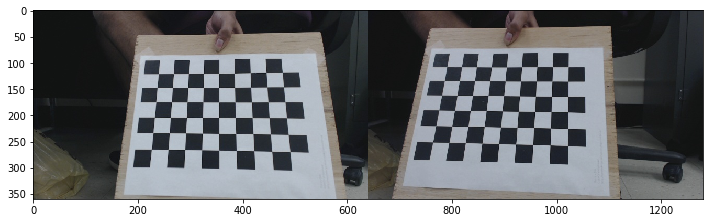

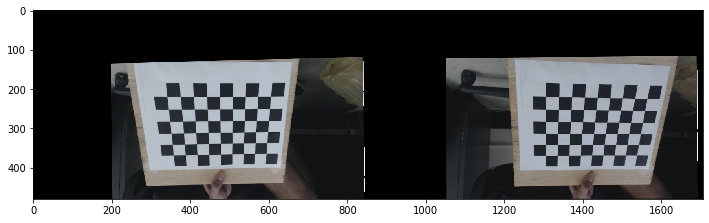

In [13]:
img_num = 0
l_img = cv2.imread(left_imgs[img_num], cv2.IMREAD_COLOR)[:,:,::-1]
r_img = cv2.imread(right_imgs[img_num], cv2.IMREAD_COLOR)[:,:,::-1]

l_img_rect = inverse_warp(H1, l_img, rows = 4*l_img.shape[0]//3, cols=4*l_img.shape[1]//3)
r_img_rect = inverse_warp(H2, r_img, rows = 4*l_img.shape[0]//3, cols=4*l_img.shape[1]//3)

plt.figure(figsize=(12,8))
plt.imshow(np.concatenate((l_img, r_img), axis=1))

plt.figure(figsize=(12,8))
plt.imshow(np.concatenate((l_img_rect, r_img_rect), axis=1))

#  left images: 29
# right images: 29

# cb pts , cb dtype , cb shape
54 , float32 , (54, 3)

Left camera:
# imgpoints:  29
ret_l 0.5835263122282806
calibration matrix:
 [[467.28856063   0.         501.58149842]
 [  0.         466.87104596 300.70649466]
 [  0.           0.           1.        ]]
distortion coefficients:
 [[ 1.14002226e-01 -2.23087642e-01  1.63996529e-03 -9.74835255e-05
  -1.16428648e-01]]

Right camera:
# imgpoints:  29
ret_r 0.5463212612066215
calibration matrix:
 [[466.86269223   0.         500.10835165]
 [  0.         466.59681383 299.46066363]
 [  0.           0.           1.        ]]
distortion coefficients:
 [[ 0.12177989 -0.1814554   0.00143827 -0.0017799   0.00044976]]

t_rect_l2r:
 [3.97060424 0.03831611 0.08503644]
R_rect_l2r:
 [[ 0.99881892 -0.01753487 -0.04531321]
 [ 0.01784273  0.99982033  0.00639844]
 [ 0.04519288 -0.00719939  0.99895234]]



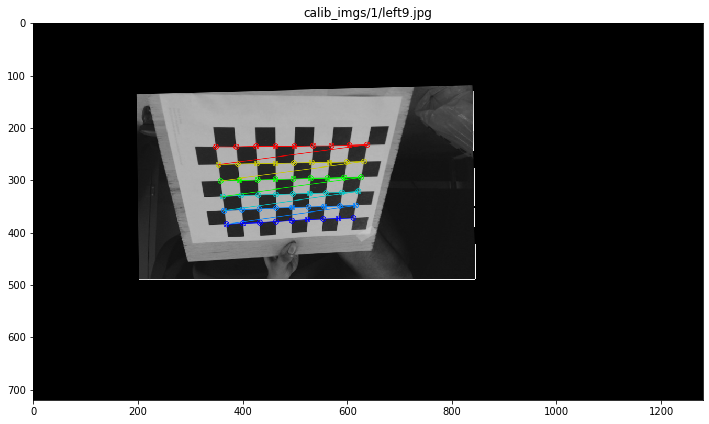

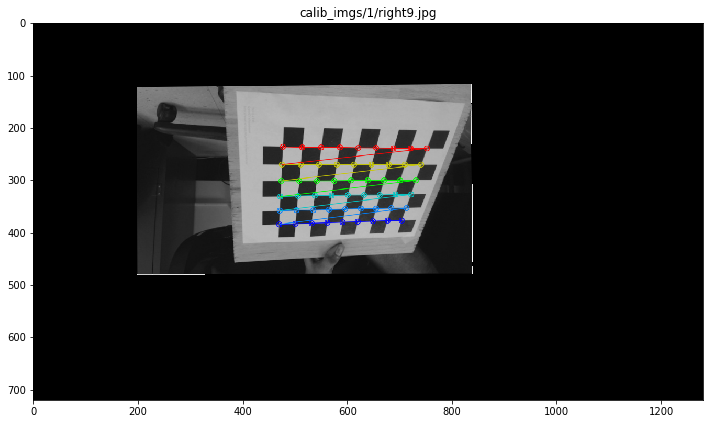

In [14]:
# get the image lists
left_imgs = sorted([f.replace('\\', '/') for f in glob.glob('calib_imgs/1/left*.jpg')])
right_imgs = sorted([f.replace('\\', '/') for f in glob.glob('calib_imgs/1/right*.jpg')])
print('#  left images:', len(left_imgs))
print('# right images:', len(right_imgs))
print()

# chessboard set-up
cb_size = (9, 6)
cb_pts = np.mgrid[0:cb_size[0], 0:cb_size[1],0:1].T.reshape(-1,3).astype(np.float32)

print('# cb pts , cb dtype , cb shape')
print(np.cumprod(cb_size)[-1], ',', cb_pts.dtype, ',', cb_pts.shape)
print()

# calibration set-up
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) # taken from opencv-python docs

# calibrate left camera
## gather the chessboard corner points
objpoints_l = []
imgpoints_rect_l = []

for img_file in left_imgs:
    img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE) # read in the image as a grayscale
    img_rect = inverse_warp(H1, img, rows=2*img.shape[0], cols=2*img.shape[1])[:,:,0]
    
    # find the chess board points
    ret, corners = cv2.findChessboardCorners(img_rect, cb_size, None)
    
    # if we found corners
    if ret == True:
        objpoints_l.append(cb_pts)
        
        # refine the corner points
        corners2 = cv2.cornerSubPix(img_rect, corners, (11,11), (-1,-1), criteria) # taken from opencv-python docs
        imgpoints_rect_l.append(corners2)
        
        
    # if
    
# for

# check the last img
draw_img = cv2.cvtColor(img_rect, cv2.COLOR_GRAY2RGB)
draw_img = cv2.drawChessboardCorners(draw_img, (9,6), corners2, ret)
plt.figure(figsize=(12,8))
plt.imshow(draw_img)
plt.title(img_file)

## perform camera calibration
print('Left camera:')
print('# imgpoints: ', len(imgpoints_rect_l))
ret_l, Krect_l, distortion_l, rvecs_rect_l, tvecs_rect_l = cv2.calibrateCamera(objpoints_l, imgpoints_rect_l, img_rect.shape[::-1],None,None)
print('ret_l', ret_l)
print('calibration matrix:\n', Krect_l)
print('distortion coefficients:\n', distortion_l)

print()

# calibrate right camera
## gather the chessboard corner points
objpoints_r = []
imgpoints_rect_r = []

for img_file in right_imgs:
    img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE) # read in the image as a grayscale
    img_rect = inverse_warp(H2, img, rows=2*img.shape[0], cols=2*img.shape[1])[:,:,0] # warp to common image plane
    
    # find the chess board points
    ret, corners = cv2.findChessboardCorners(img_rect, cb_size, None)
    
    # if we found corners
    if ret == True:
        objpoints_r.append(cb_pts)
        
        # refine the corner points
        corners2 = cv2.cornerSubPix(img_rect, corners, (11,11), (-1,-1), criteria) # taken from opencv-python docs
        imgpoints_rect_r.append(corners2)
        
        
    # if
    
# for

# check the last img
draw_img = cv2.cvtColor(img_rect, cv2.COLOR_GRAY2RGB)
draw_img = cv2.drawChessboardCorners(draw_img, (9,6), corners2, ret)
plt.figure(figsize=(12,8))
plt.imshow(draw_img)
plt.title(img_file)

## perform camera calibration
print('Right camera:')
print('# imgpoints: ', len(imgpoints_rect_r))
ret_r, Krect_r, distortion_r, rvecs_rect_r, tvecs_rect_r = cv2.calibrateCamera(objpoints_r, imgpoints_rect_r, img_rect.shape[::-1],None,None)
print('ret_r', ret_r)
print('calibration matrix:\n', Krect_r)
print('distortion coefficients:\n', distortion_r)

print()

# get the transform
i = 0
t_rectl1 = tvecs_rect_l[i].reshape(-1, 1)
R_rectl1 = cv2.Rodrigues(rvecs_rect_l[i])[0].T
t_rectl1 = -R_rectl1 @ t_rectl1

t_rectr1 = tvecs_rect_r[i].reshape(-1,1)
R_rectr1 = cv2.Rodrigues(rvecs_rect_r[i])[0].T
t_rectr1 = -R_rectr1 @ t_rectr1

# compute R_l2r = inv(R_l) @ R_r
R_rect_l2r = R_rectr1.T @ R_rectl1
t_rect_l2r = R_rectr1.T @ (t_rectl1 - t_rectr1)

print('t_rect_l2r:\n', t_rect_l2r.reshape(-1))
print('R_rect_l2r:\n', R_rect_l2r)
print()